# Imports

In [6]:
!pip install finesse
import numpy as np
import matplotlib.pyplot as plt
import finesse
#from finesse.analysis.actions import RunLocks
finesse.configure(plotting=True)
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Detector Setup

We initialize a DRMI optical configuration. The configuration was sourced from the [finesse 3 docs.](https://finesse.ifosim.org/docs/latest/usage/lti/loops.html)

An image of the setup courtesy of [Effler, 2014](https://repository.lsu.edu/gradschool_dissertations/2888/):
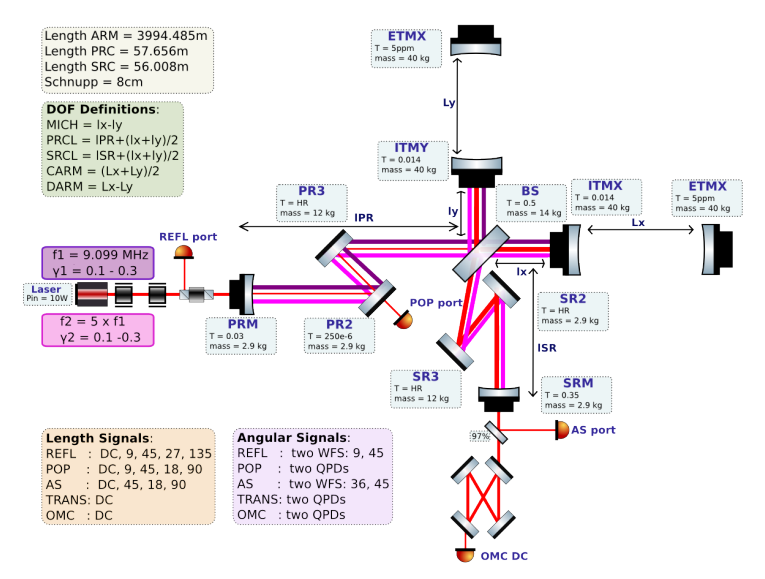

In [158]:
# Initialize model

kat = finesse.Model()

# Model config

kat.parse(

"""

##########################################################################
### Variables
##########################################################################

var Larm 2999.8
var Lprc 12
var Lsrc 12
var Mtm 40
var prmT 0.04835
var itmT 0.01377
var srmT 0.325
var lmichx 5.3662
var lmichy 5.244
var f1 6270777
var f2 9*f1
var f3 4/3*f1

##########################################################################
### Input optics
##########################################################################

l L0 125
s l_mod1 L0.p1 eo1.p1
mod eo1 f1 0.1 order=1
s l_mod2 eo1.p2 eo2.p1
mod eo2 f2 0.1 order=1
s l_mod3 eo2.p2 eo3.p1
mod eo3 f3 0.1 order=1
s l_in eo3.p2 prm.p1 L=53

#Power recycling mirror
m prm T=prmT L=30u Rc=-1430
s l_prc prm.p2 bs.p1 L=Lprc

# Central beamsplitter
bs bs T=0.5 L=0 alpha=45

##########################################################################
### X arm
##########################################################################

s lx bs.p3 itmx.p1 L=lmichx
m itmx T=itmT L=37.5u phi=90 Rc=-1424.6
s LX itmx.p2 etmx.p1 L=Larm
m etmx T=5u L=37.5u phi=90 Rc=1695.0

##########################################################################
### Y arm
##########################################################################

s ly bs.p2 itmy.p1 L=lmichy
m itmy T=itmT L=37.5u phi=0 Rc=-1424.5
s LY itmy.p2 etmy.p1 L=Larm
m etmy T=5u L=37.5u phi=0.0 Rc=1696.0

##########################################################################
### Signal Recyling Cavity
##########################################################################

s l_src bs.p4 srm.p1 L=Lsrc
m srm T=srmT L=30u Rc=1430.0

##########################################################################
### Degrees of Freedom, Readouts, and Locks
##########################################################################

dof DARM etmx.dofs.z -1 etmy.dofs.z +1
dof CARM etmx.dofs.z +1 etmy.dofs.z +1
dof MICH itmx.dofs.z -1 etmx.dofs.z -1 itmy.dofs.z +1 etmy.dofs.z +1
dof PRCL prm.dofs.z +1 DC=90
dof SRCL srm.dofs.z -1

readout_rf rd_sr_f1 srm.p2.o f=eo1.f phase=0 output_detectors=True
readout_rf rd_pr_f1 prm.p1.o f=eo1.f phase=0 output_detectors=True
readout_rf rd_pr_f2 prm.p1.o f=eo2.f phase=0 output_detectors=True
readout_rf rd_pr_f3 prm.p1.o f=eo3.f phase=0 output_detectors=True

"""

)

In [8]:
kat.modes('off')

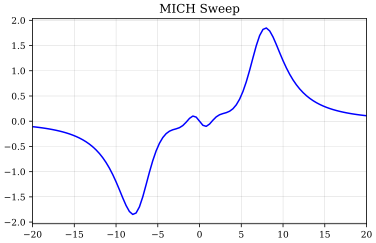

In [9]:
results = kat.run("xaxis(MICH.DC, lin, -20, 20, 100, relative=False)")

plt.plot(results.x[0], results['rd_pr_f2_Q'])
plt.title("MICH Sweep")
plt.show()

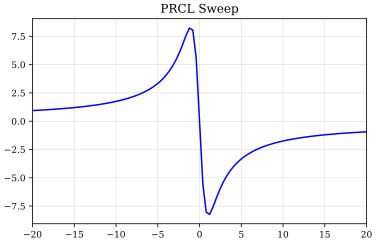

In [ ]:
results = kat.run("xaxis(PRCL.DC, lin, -20, 20, 100, relative=True)")

plt.plot(results.x[0], results['rd_pr_f3_I'])
plt.title("PRCL Sweep")
plt.show()

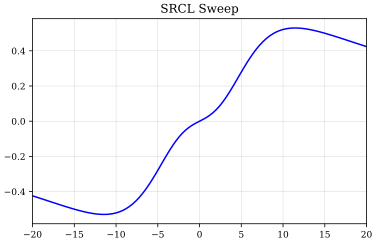

In [ ]:
results = kat.run("xaxis(SRCL.DC, lin, -20, 20, 100, relative=True)")

plt.plot(results.x[0], results['rd_pr_f2_I'])
plt.title("SRCL Sweep")
plt.show()

# Synthetic Dataset Generation

For each DOF, we sample ~50 datapoints to generate 50^3 datapoints in our dataset

In [ ]:
# Dict to store dataset
data = {
    'MICH': [],
    'PRCL': [],
    'SRCL': [],
    'MICH_signal': [],
    'PRCL_signal': [],
    'SRCL_signal': []
}

In [160]:
def get_PDH(finesse_model):
    """Helper function to retrieve the PDH error signals from the model"""
    MICH_signal = finesse_model['rd_pr_f2_Q']
    PRCL_signal = finesse_model['rd_pr_f3_I']
    SRCL_signal = finesse_model['rd_pr_f2_I']

    return MICH_signal, PRCL_signal, SRCL_signal

In [140]:
center = 0
std_deviation = 5
num_points = 50
samples = np.random.normal(loc=center, scale=std_deviation, size=num_points)
samples = np.abs(samples)

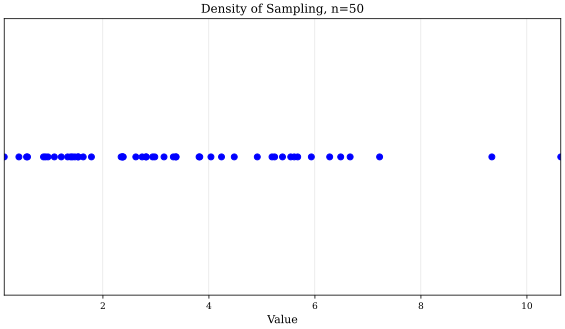

In [141]:
plt.figure(figsize=(10, 5))
plt.scatter(samples, np.zeros_like(samples), color='blue')
plt.yticks([], [])
plt.xlabel('Value')
plt.title(f'Density of Sampling, n={num_points}')
plt.grid(True)
plt.show()

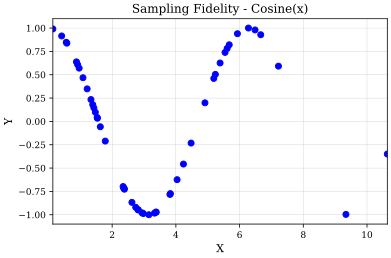

In [142]:
plt.title('Sampling Fidelity - Cosine(x)')
plt.scatter(samples, np.cos(samples))
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
# This code was run on a cluster

# Range of input values
MICH_range = samples
PRCL_range = samples + 90 # shifting PRCL range
SRCL_range = samples

# Iterates through range of input values
for MICH in MICH_range:
    kat.MICH.DC = MICH
    for PRCL in PRCL_range:
        kat.PRCL.DC = PRCL
        for SRCL in SRCL_range:
            kat.SRCL.DC = SRCL

            result = kat.run() # Runs the simulation
            MICH_signal, PRCL_signal, SRCL_signal = get_PDH(result) # Grabs the error signals

            # Adds the datapoint to the data object
            data['MICH'].append(MICH)
            data['PRCL'].append(PRCL)
            data['SRCL'].append(SRCL)
            data['MICH_signal'].append(MICH_signal)
            data['PRCL_signal'].append(PRCL_signal)
            data['SRCL_signal'].append(SRCL_signal)


# Neural Network Training

In [ ]:
class NeuralNetworkEnsemble:
    """
    A class representing an ensemble of neural networks for regression tasks (W.I.P).

    Attributes:
        input_cols (list): A list of column names representing the input features.
        output_cols (list): A list of column names representing the output targets.
        num_networks (int): The number of neural networks in the ensemble.
        models (list): A list to store individual neural network models.

    Methods:
        train_models(X_train, y_train):
            Trains multiple neural networks on the training data.
    """

    def __init__(self, input_cols, output_cols, num_networks):
        """
        Initializes the NeuralNetworkEnsemble object.

        Parameters:
            input_cols (list): A list of column names representing the input features.
            output_cols (list): A list of column names representing the output targets.
            num_networks (int): The number of neural networks in the ensemble.
        """
        self.input_cols = input_cols
        self.output_cols = output_cols
        self.num_networks = num_networks
        self.models = []

    def train_models(self, X_train, y_train):
        """
        Trains multiple neural networks on the training data.

        Parameters:
            X_train (ndarray): Input features for training.
            y_train (ndarray): Output targets for training.
        """
        for i in range(self.num_networks):
            model = tf.keras.models.Sequential([
                tf.keras.layers.Dense(64, activation='relu', input_shape=(len(self.input_cols),)),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(1)  # Output layer with one neuron for regression
            ])
            model.compile(optimizer='adam', loss='mean_squared_error')
            model.fit(X_train, y_train[:, i], epochs=50, batch_size=32, validation_split=0.2, verbose=0)
            self.models.append(model)

In [69]:
# Load the DataFrame
final_df = pd.read_pickle("final_df.pkl")

# Shifting PRCL for training
final_df['PRCL'] -= 90

# Define input and output columns
input_cols = ['MICH', 'PRCL', 'SRCL']
output_cols = ['MICH_signal', 'PRCL_signal', 'SRCL_signal']

# Split the data into input and output
X = final_df[input_cols].values
y = final_df[output_cols].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the number of neural networks in the ensemble
num_networks = len(output_cols)

# Create an instance of the NeuralNetworkEnsemble class
ensemble = NeuralNetworkEnsemble(input_cols, output_cols, num_networks)

# Train the ensemble of neural networks
ensemble.train_models(X_train, y_train)

# Evaluate the ensemble
ensemble.evaluate(X_test, y_test)

898/898 [==============================] - 1s 1ms/step
Ensemble Mean Squared Error: 0.002767285002615804


In [78]:
# Extracts each model from the ensemble
MICH_signal_nn = ensemble.models[0]
PRCL_signal_nn = ensemble.models[1]
SRCL_signal_nn = ensemble.models[2]

# Neural Network Results

### MICH Signal

Fixing SRCL = 0 = PRCL


In [ ]:
# Makes the model predictions
xx = np.linspace(0, 20, 100)
yy = []
for x in xx:
    yy.append(MICH_signal_nn.predict([[x, 0, 0]]))

MICH_yy = np.array(yy).flatten()

# Extends the model from odd symmetry
extended_xx = np.concatenate((-np.flip(xx[1:]), xx))
extended_MICH_yy = np.concatenate((-np.flip(MICH_yy[1:]), MICH_yy))

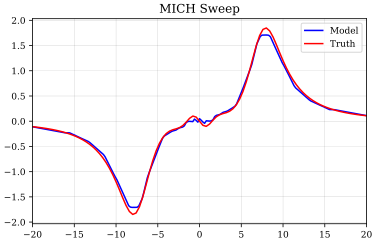

In [148]:
# Plots model
plt.plot(extended_xx, extended_MICH_yy, label='Model')

# Plots Truth
results = kat.run("xaxis(MICH.DC, lin, -20, 20, 100, relative=False)")
plt.plot(results.x[0], results['rd_pr_f2_Q'], label="Truth")
plt.title("MICH Sweep")

plt.legend()
plt.show()

### PRCL Signal

Fixing MICH = 0 = SRCL

In [ ]:
# Makes model predictions
xx = np.linspace(0, 20, 100)
yy = []
for x in xx:
    yy.append(PRCL_signal_nn.predict([[0, x, 0]]))
PRCL_yy = np.array(yy).flatten()

# Extends model from odd symmetry
extended_xx = np.concatenate((-np.flip(xx[1:]), xx))
extended_PRCL_yy = np.concatenate((-np.flip(PRCL_yy[1:]), PRCL_yy))

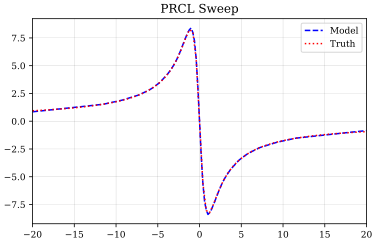

In [150]:
# Model plot
plt.plot(extended_xx, extended_PRCL_yy, label = 'Model', linestyle='--')

# Truth
results = kat.run("xaxis(PRCL.DC, lin, -20, 20, 100, relative=True)")
plt.plot(results.x[0], results['rd_pr_f3_I'], label = "Truth", linestyle=':')

plt.title("PRCL Sweep")
plt.legend()
plt.show()

### SRCL Signal

Fixing MICH = 0 = PRCL

In [ ]:
xx = np.linspace(0, 20, 100)
yy = []
for x in xx:
    yy.append(SRCL_signal_nn.predict([[0, 0, x]]))

SRCL_yy = np.array(yy).flatten()

extended_xx = np.concatenate((-np.flip(xx[1:]), xx))
extended_SRCL_yy = np.concatenate((-np.flip(SRCL_yy[1:]), SRCL_yy))

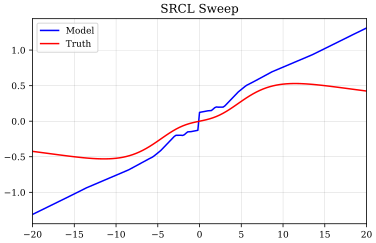

In [139]:
plt.plot(extended_xx, extended_SRCL_yy, label='Model')

results = kat.run("xaxis(SRCL.DC, lin, -20, 20, 100)")
plt.plot(results.x[0], results['rd_pr_f2_I'], label = 'Truth')
plt.title("SRCL Sweep")
plt.legend()
plt.show()

### Further Testing (WIP)

In [175]:
def set_DC(model, MICH_value, PRCL_value, SRCL_value):
    model.MICH.DC = MICH_value
    model.PRCL.DC = PRCL_value
    model.SRCL.DC = SRCL_value

    return model

In [178]:
def ground_truth(model, MICH, PRCL, SRCL):
    return get_PDH(set_DC(model, MICH, PRCL, SRCL).run())

In [ ]:
# Makes model predictions
xx = np.linspace(0, 20, 100)
yy = []
for x in xx:
    yy.append(PRCL_signal_nn.predict([[5, x, 0]]))
PRCL_yy = np.array(yy).flatten()

# Extends model from odd symmetry
extended_xx = np.concatenate((-np.flip(xx[1:]), xx))
extended_PRCL_yy = np.concatenate((-np.flip(PRCL_yy[1:]), PRCL_yy))

In [193]:
truths = []

for x in xx:
    truth = ground_truth(kat, 5, x, 0)[1]
    truths.append(truth)

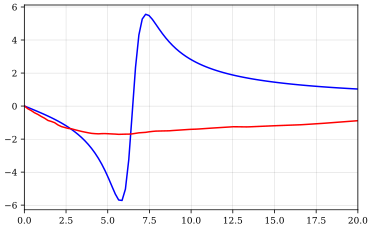

In [194]:
plt.plot(xx, truths)
plt.plot(xx, PRCL_yy)